In [1]:
%matplotlib notebook
#%matplotlib inline
import numpy as np
from numpy.random import RandomState
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
#from os.path import join
import ipywidgets as widgets
from IPython.display import display
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable
import pickle
from torchsampler import ImbalancedDatasetSampler
#from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix, classification_report
from tqdm.notebook import tqdm

In [2]:
# original

class LightCurveRRL_Dataset(Dataset):
    def __init__(self, df_metadata, folder_name, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["OGLE_period"]
        self.label = torch.from_numpy(df_metadata["label"].values)
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        column_names_fill = ["mjd", "mag", "err", "phase", "mask"]
        self.folder = folder_name
        #self.classes = ["T2C", "ECL"]
        df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
                
        for i in range(len(df_metadata)):
            rrl_data = pd.read_csv(join(data_path, self.folder, self.name[i]+'.dat'), 
                                  header=None, delim_whitespace=True, comment='#', names=column_names_lc)
            #rrl_data.sort_values(by="mjd", inplace=True)
            rrl_data["phase"] = np.mod(rrl_data["mjd"], self.period[i])/self.period[i]
            #normalize
            mag_std = rrl_data["mag"].std()
            rrl_data["mjd"] = rrl_data["mjd"]-rrl_data["mjd"].min()
            rrl_data["mag"] = (rrl_data["mag"]-rrl_data["mag"].mean())/mag_std
            rrl_data["err"] = rrl_data["err"]/mag_std
            rrl_data.sort_values(by="phase", inplace=True)
            # ajustar todas a largo 335, rellenando con 0s las que sean mas pequeñas,
            # asignando un label '1' si es dato real y '0' si es dato rellenado.
            if len(rrl_data) == 335:
                rrl_data["mask"] = 1
            else:
                while len(rrl_data) < 335:
                    #RELLENAR con 0s;
                    rrl_data = rrl_data.append(df_zeros, ignore_index=True,sort=False)
            rrl_data = rrl_data.fillna(1)
            rrl_data = rrl_data[["phase","mag","err","mjd","mask"]]
            self.data.append(torch.from_numpy(rrl_data.values.astype('float32')))
            
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def plot(self, idx, ax):
        assert len(ax)==2, "Needs two subaxis"
        ax[0].cla()  
        ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[0].invert_yaxis()
        ax[1].cla()
        ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[1].invert_yaxis()
        ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))

    def __len__(self):
        return len(self.data)

In [3]:
classes = ('ECL_Contact', 'ECL_No-Contact', 'Ellipsoid','RRL_AB', 'RRL_C')

In [4]:
def count_classes(datos):
    assert int(datos[0]['label'].item())==0
    classes=[[0,0],[1,0],[2,0],[3,0],[4,0]]
    for data in datos:
        label = int(data['label'].item())
        #print(label)
        if label == 0:
            classes[0][1]+=1
        elif label == 1:
            classes[1][1]+=1
        elif label == 2:
            classes[2][1]+=1
        elif label == 3:
            classes[3][1]+=1
        elif label == 4:
            classes[4][1]+=1
    return classes

In [5]:
with open('PhaseSorted_NotInterp_ecl_c.pkl', 'rb') as handle:
    vvv_ecl_c = pickle.load(handle)
#label 0

In [6]:
with open('PhaseSorted_NotInterp_ecl_nc.pkl', 'rb') as handle:
    vvv_ecl_nc = pickle.load(handle)
#label 1

In [7]:
with open('PhaseSorted_NotInterp_ell.pkl', 'rb') as handle:
    vvv_ell = pickle.load(handle)
#label 2

In [8]:
with open('PhaseSorted_NotInterp_rrab.pkl', 'rb') as handle:
    vvv_rrab = pickle.load(handle)
#label 3

In [9]:
with open('PhaseSorted_NotInterp_rrc.pkl', 'rb') as handle:
    vvv_rrc = pickle.load(handle)
#label 4

In [10]:
VVV = torch.utils.data.ConcatDataset([vvv_ecl_c, vvv_ecl_nc, vvv_ell,vvv_rrab, vvv_rrc])
#VVV = torch.utils.data.ConcatDataset([vvv_ell, vvv_rrc])


In [11]:
# implementacion adaptada a 1D de https://github.com/naoto0804/pytorch-inpainting-with-partial-conv

class PartialConv(nn.Module):
    def __init__(self, in_channels_C,in_channels_M, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.input_conv = nn.Conv1d(in_channels_C, out_channels, kernel_size,
                                    stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv1d(in_channels_M, out_channels, kernel_size,
                                   stride, padding, dilation, groups, False)
        # self.input_conv.apply(weights_init('kaiming'))

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self,input, mask):
        # http://masc.cs.gmu.edu/wiki/partialconv
        # C(X) = W^T * X + b, C(0) = b, D(M) = 1 * M + 0 = sum(M)
        # W^T* (M .* X) / sum(M) + b = [C(M .* X) – C(0)] / D(M) + C(0)
        #print(input.shape, mask.shape)
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        no_update_holes = output_mask == 0
        mask_sum = output_mask.masked_fill_(no_update_holes, 1.0)

        output_pre = (output - output_bias) / mask_sum + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)

        new_mask = torch.ones_like(output)
        new_mask = new_mask.masked_fill_(no_update_holes, 0.0)

        return output, new_mask

In [165]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels_C=2,in_channels_M=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=5): 
        super(MLP, self).__init__()
        self.pconv1 = PartialConv(in_channels_C,in_channels_M, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv2 = PartialConv(c4, c4, c3, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv3 = PartialConv(c3, c3, c3, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pconv4 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.gap = torch.nn.AdaptiveMaxPool1d(1)
        
        self.hidden1 = torch.nn.Linear(c3*1, hid2_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid2_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=False)

        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    def forward(self, x,mask, t=0):
        if t==1:
            x = x.transpose(0,1)
            mask = mask.transpose(0,1)
        elif t==2:
            #x = x.transpose(1,2)
            mask = mask.transpose(1,2)
    
        x, mask = self.pconv1(x, mask)
        x = self.activation(x)
        x, mask = self.pconv2(x, mask)
        x = self.activation(x)
        x, mask = self.pconv3(x, mask)
        x = self.activation(x)
        #x, mask = self.pconv4(x, mask)
        z = self.gap(x)
        z = z.reshape(-1,32*1)
        z = self.activation(self.hidden1(z))
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        fuera = self.output(z)
        return fuera



In [81]:
class MLP_gap(torch.nn.Module):
    def __init__(self, in_channels_C=2,in_channels_M=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=5): 
        super(MLP_gap, self).__init__()
        self.pconv1 = PartialConv(in_channels_C,in_channels_M, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv2 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv3 = PartialConv(c4, c4, c2, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pconv4 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
        #                                 ceil_mode=False, count_include_pad=True)
        self.gap = torch.nn.AdaptiveMaxPool1d(1)
        
        self.hidden1 = torch.nn.Linear(c2*1, hid_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=True)

        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    def forward(self, x,mask, t=0):
        if t==1:
            x = x.transpose(0,1)
            mask = mask.transpose(0,1)
        elif t==2:
            #x = x.transpose(1,2)
            mask = mask.transpose(1,2)
    
        x, mask = self.pconv1(x, mask)
        x = self.activation(x)
        x, mask = self.pconv2(x, mask)
        x = self.activation(x)
        x, mask = self.pconv3(x, mask)
        x = self.activation(x)
        #x, mask = self.pconv4(x, mask)
        z = self.gap(x)
        z = z.reshape(-1,64*1)
        z = self.activation(self.hidden1(z))
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        fuera = self.output(z)
        return fuera


In [78]:
class MLP_last(torch.nn.Module):
    def __init__(self, in_channels_C=2,in_channels_M=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=5): 
        super(MLP_last, self).__init__()
        self.pconv1 = PartialConv(in_channels_C,in_channels_M, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv2 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv3 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pconv4 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
        #                                 ceil_mode=False, count_include_pad=True)
        self.gap = torch.nn.AdaptiveMaxPool1d(10)
        
        self.hidden1 = torch.nn.Linear(c4*10, hid2_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid2_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=True)

        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    def forward(self, x,mask, t=0):
        if t==1:
            x = x.transpose(0,1)
            mask = mask.transpose(0,1)
        elif t==2:
            #x = x.transpose(1,2)
            mask = mask.transpose(1,2)
    
        x, mask = self.pconv1(x, mask)
        x = self.activation(x)
        x, mask = self.pconv2(x, mask)
        x = self.activation(x)
        x, mask = self.pconv3(x, mask)
        x = self.activation(x)
        #x, mask = self.pconv4(x, mask)
        z = self.gap(x)
        z = z.reshape(-1,16*10)
        z = self.activation(self.hidden1(z))
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        fuera = self.output(z)
        return fuera



In [13]:
class simple_dataset(Dataset):    
    def __init__(self, data, targets,transform=None):
        assert torch.is_tensor(data)==True and torch.is_tensor(targets)==True
        self.data=data
        self.labels=targets
        self.transform=transform
    
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.data)

In [14]:
def make_dataset(indices):
    targets = [VVV[i]['label'].item() for i in indices]
    targets = torch.tensor(targets,dtype=torch.long)
    LC_magData = [VVV[i]['data'][:,1].numpy() for i in indices]
    LC_errData = [VVV[i]['data'][:,2].numpy() for i in indices]
    LC_mask = [VVV[i]['data'][:,4].numpy() for i in indices]
    LC_magData = torch.tensor(LC_magData)
    LC_errData = torch.tensor(LC_errData)
    LC_mask = torch.tensor(LC_mask)
    mag_err_mask=torch.stack((LC_magData,LC_errData,LC_mask),dim=1)
    # Dataset
    LC_Dataset = simple_dataset(mag_err_mask, targets)
    return LC_Dataset

In [ ]:
k=np.random.randint(len(VVV))

VVV[k]['data'][:,4]

In [ ]:
def phase_rotation_indices(datos):
    whole_ind = range(len(datos))
    #print(whole_ind)
    #whole=datos[:,1]
    n=sum(datos[:,4]==1).item()
    #print(range(n))
    #data,zeros=whole[:n],whole[-(len(whole)-n):]
    data_ind,zeros_ind=whole_ind[:n],whole_ind[-(len(datos)-n):]
    #return data,zeros,n
    r=np.random.randint(n/2,n)
    #r=int(n/2)
    #extracto,resto=data[-r:],data[:n-r]
    extract_ind,resto_ind=data_ind[-r:],data_ind[:n-r]
    new_ind = np.concatenate((extract_ind,resto_ind),axis=0)
    #new_lc = whole[new_ind]
    #new_lc = torch.cat((extracto,resto),dim=0)
    print(r,new_ind)
    return new_ind


    
def plotea2(datos1,k,ax,classes):
    n=sum(datos1[k]['data'][:,4]==1).item()
    lc=datos1[k]['data']
    pha1 = datos1[k]['data'][:n,0]
    #pha1= np.linspace(0,1,n)
    mag1 = datos1[k]['data'][:n,1]
    err1 = datos1[k]['data'][:n,2]
    r=np.random.randint(n/2,n)
    mag2= np.concatenate((mag1[-r:],mag1[:n-r]),axis=0)
    pha2= np.concatenate((pha1[-r:],pha1[:n-r]),axis=0)
    err2= np.concatenate((err1[-r:],err1[:n-r]),axis=0)
    #rot_ind = phase_rotation_indices(lc)
    #pha2 = pha1[rot_ind]
    #mag2 = mag1[rot_ind]
    #err2 = err1[rot_ind]
    #mag2 = mag1+torch.randn_like(mag1)*err1
    #pha2= np.linspace(0,1,len(mag2))
    #err2 = torch.zeros_like(err1)
    #err3= np.zeros(len(pha2))
    lab = datos1[k]['label'].item()
    #[ax_.cla() for ax_ in ax]
    ax.cla()
    #ax.plot(phi, mag, lw=2, c='r')
    #ax[2].errorbar(pha1,mag1,err2, fmt='.')
    #ax[2].invert_yaxis()
    ax.errorbar(pha1,mag1,err1,fmt='b.')
    #ax.set_title("estrella tipo %s, k=%d, %d pts,%d mov" %(classes[lab],k,n,(100-100*r/n)))
    ax.invert_yaxis()
    #ax.errorbar(pha1,mag2,err2, fmt='r.')
    ax.set_title("rotated estrella tipo %s, k=%d, %d pts,%d mov" %(classes[lab],k,n,(100-100*r/n)))
    #ax[1].invert_yaxis()
    plt.show()

In [ ]:
count_classes(VVV)

In [ ]:
np.random.randint?

In [ ]:
examples=list()
ecl_nc_rare=list()

In [ ]:
n1=17882
n2=21880
n3=789
n4=21123
k=0
#k=np.random.randint(len(examples))
#k=np.random.randint(n1+n2+n3,n1+n2+n3+n4)
ant=0
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)

plotea(lc_debug,k,ax,classes)
b1 = widgets.Button(description="Otra")
bx = widgets.Button(description="delet dis")
b2 = widgets.Button(description="Save Example")
b3 = widgets.Button(description="Save Rare")
b4 = widgets.Button(description="Anterior")
display(widgets.HBox([b1,b4]))
#display(widgets.HBox([b1,b4,b2,b3]))

def on_button_clicked(b):
    global k, examples,ecl_nc_rare,ant
    if b.description == "Save Rare":
        #print("not implemented.")
        ecl_nc_rare.append(VVV[k])
        #examples.append(VVV[k])
        print("Rara guardada, k=",k, len(ecl_nc_rare))
    elif b.description == "Save Example":
        #print("not implemented.")
        #ecl_nc_rare.append(VVV[k])
        examples.append(VVV[k])
        print("Guardada, k=",k, len(examples))
    elif b.description== "Anterior":
        plotea(lc_debug,ant, ax,classes)
    elif b.description== "delet dis":
        examples.pop(k)
        print("estrella borrada", k, len(examples))
        k=np.random.randint(len(examples))
        plotea(examples,k, ax,classes)
    else:
        ant=k
        if k<len(lc_debug)-1:
            k+=1
        else:
            k=0
        #k=np.random.randint(len(lc_debug))
        #k = np.random.randint(n1+n2+n3,n1+n2+n3+n4)
        #print(k)
        plotea(lc_debug,k, ax,classes)
        #plotea(VVV_pha,k, ax,classes)

    
b1.on_click(on_button_clicked)
b2.on_click(on_button_clicked)
b3.on_click(on_button_clicked)
b4.on_click(on_button_clicked)
bx.on_click(on_button_clicked)
#lc = torch.cat((new_lc,zeros),dim=0)
#display(lc)


In [ ]:
lc_debug = [examples[15],examples[11],examples[3],examples[13],examples[14],examples[5]]

In [ ]:
with open('lc_debug.pkl', 'wb') as handle:
    pickle.dump(lc_debug, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
pts100 = list()
for i in VVV:
    mask=i['data'][:,4]
    if sum(mask)>=100:
        pts100.append(i)
print(len(pts100))

In [133]:
int(sum(VVV[600]['data'][:,4]).item())

77

In [15]:
cajones=[[],[],[],[],[]]
for i in range(len(VVV)):
    mask=VVV[i]['data'][:,4]
    lc_pts=int(sum(mask).item())
    if lc_pts>=51 and lc_pts<=107:
        cajones[0].append(i)
    elif lc_pts>107 and lc_pts<=164:
        cajones[1].append(i)
    elif lc_pts>164 and lc_pts<=221:
        cajones[2].append(i)
    elif lc_pts>221 and lc_pts<=278:
        cajones[3].append(i)
    elif lc_pts>278 and lc_pts<=335:
        cajones[4].append(i)


In [140]:
cajones_len=[]
for c in cajones:
    cajones_len.append(len(c))
    print("{:.2f}".format(len(c)/len(VVV)*100))
print(cajones_len)

86.98
0.12
0.25
0.84
11.81
[58365, 78, 171, 563, 7926]


In [87]:
#path_gap='/home/amorales/models/best_LCC_model_AMP1__Rot'+str(1)+'_Alpha'+str(0.75)+'_sampleo'+str(0)+'.pt'
#path_nogap='/home/amorales/models/best_LCC_model_NoPool__Rot'+str(0)+'_Alpha'+str(1)+'_sampleo'+str(0)+'.pt'
path_last10= '/home/amorales/models/best_LCC_model_lastAMP10__Rot'+str(1)+'_Alpha'+str(1)+'_sampleo'+str(1)+'.pt'
path_lastgap= '/home/amorales/models/best_LCC_model_last__Rot'+str(0)+'_Alpha'+str(0.75)+'_sampleo'+str(2)+'.pt'
#best_gap,best_nogap = MLP(),MLP_()
best_last10, best_lastgap = MLP_last(), MLP_gap()
best_last10.load_state_dict(torch.load(path_last10)['model_state_dict'])
best_lastgap.load_state_dict(torch.load(path_lastgap)['model_state_dict'])
#best_gap.load_state_dict(torch.load(path_gap)['model_state_dict'])
#best_nogap.load_state_dict(torch.load(path_nogap)['model_state_dict'])

<All keys matched successfully>

In [88]:
for i,c in enumerate(cajones):
    #f1_acum=0.0
    y_trues,y_preds=list(),list()
    #LC_dataset=make_dataset(c)
    for idx in c:
        data,label=VVV[idx]['data'],VVV[idx]['label']
        y_trues.append(label.numpy())
        #print(y_true)
        #n = sum(data[:,4]==1).item()
        #print(n)
        pha = data[:,0]
        mag = data[:,1]
        err = data[:,2]
        data2=torch.stack((mag,err))
        data,mask = data2.unsqueeze(0),data[:,4].unsqueeze(-1).unsqueeze(0).transpose(1,2)
        outputs=best_lastgap.forward(data,mask,t=0)
        # F1 score
        y_preds.append(outputs.detach().argmax(dim=1).item())
        #print(y_pred)
    f1sc=f1_score(y_trues, y_preds,average='weighted')    
    print(f1sc)
    

0.6725287818682775
0.3362307283359915
0.3213931861437149
0.4065295099147362
0.49154180354661614


### Desempeño por Cajones

#### Last AMP=10
- 0.653261895716323
- 0.3008023722309436
- 0.4799841175738679
- 0.47358158341611645
- 0.622472290777339

#### Last GAP
- 0.6725287818682775
- 0.3362307283359915
- 0.3213931861437149
- 0.4065295099147362
- 0.49154180354661614


#### GAP
- 0.6675970054872494
- 0.4116322663187563
- 0.3532085684346882
- 0.34112652661876103
- 0.49296052945871294

#### No GAP
- 0.2249251853468325
- 0.4167737024879881
- 0.4370811317733708
- 0.41071183147632695
- 0.5564315159677246



In [93]:
# amp10, last_amp10, gap, last_gap
pts_results = [[0.2249252,0.4167737,0.4370811,0.4107118,0.5564315],
               [0.6532619,0.3008024,0.4799841,0.4735816,0.6224723],
               [0.6675970,0.4116323,0.3532086,0.3411265,0.4929605],
               [0.6725288,0.3362307,0.3213932,0.4065295,0.4915418]]

In [100]:
xtick=np.linspace(51,335,5)
#xtick=np.arange(0, 1, step=0.2)
# np.arange(0, 1.5, step=0.25)
xtick

array([ 51., 122., 193., 264., 335.])

In [101]:
xticklabels=['[51-107]','[108-164]','[165-221]','[222-278]','[278-335]']

<IPython.core.display.Javascript object>


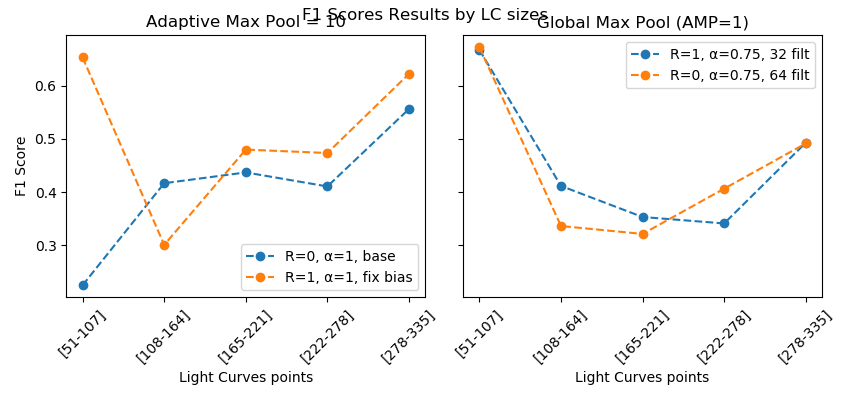

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4),tight_layout=True,sharex=True,sharey=True)
fig.suptitle('F1 Scores Results by LC sizes')
ax[0].set_title('Adaptive Max Pool = 10')
ax[1].set_title('Global Max Pool (AMP=1)')
[ax_.set_xticks(xtick) for ax_ in ax]
[ax_.set_xticklabels(xticklabels,rotation=45) for ax_ in ax]

ax[0].plot(xtick,pts_results[0],'o--',label='R=0, α=1, base')
ax[0].plot(xtick,pts_results[1],'o--',label='R=1, α=1, fix bias')
ax[1].plot(xtick,pts_results[2],'o--',label='R=1, α=0.75, 32 filt')
ax[1].plot(xtick,pts_results[3],'o--',label='R=0, α=0.75, 64 filt')

ax[0].set_ylabel('F1 Score')
[ax_.set_xlabel('Light Curves points') for ax_ in ax]
[ax_.legend() for ax_ in ax]

In [ ]:
pts70 = list()
for i in VVV:
    mask=i['data'][:,4]
    if sum(mask)<=70:
        pts70.append(i)
print(len(pts70))

In [ ]:
count_classes(lc_debug)

In [ ]:
mag_ = mag+torch.randn_like(mag)*err

In [ ]:
torch.zeros_like?

In [ ]:
def plotea(datos, k, ax,classes):
    #assert len(ax)==1, "Needs one subaxis"
    n = sum([1 for i in datos[k]['data'][:,4]==1 if i==True])
    #print(n)
    l = datos[k]['label'].item()
    pha=datos[k]['data'][:n,0]
    mag=datos[k]['data'][:n,1]
    err=datos[k]['data'][:n,2]
    ax.cla()
    ax.errorbar(pha, mag, err, fmt='.')
    ax.invert_yaxis()
    ax.set_title("estrella tipo %s, pts=%d, k=%d" %(classes[l],n,k))

def plotea2(datos1,k,ax,classes):
    n = sum([1 for i in datos1[k]['data'][:,4]==1 if i==True])
    pha1 = datos1[k]['data'][:n,0]
    mag1 = datos1[k]['data'][:n,1]
    err1 = datos1[k]['data'][:n,2]
    #pha2 = datos2[k]['data'][:n,0]
    mag2 = mag1+torch.randn_like(mag1)*err1
    #err2 = torch.zeros_like(err1)
    lab = datos1[k]['label'].item()
    [ax_.cla() for ax_ in ax]
    #ax.plot(phi, mag, lw=2, c='r')
    ax[0].errorbar(pha1,mag1,err1, fmt='.')
    ax[0].set_title("estrella tipo %s, k=%d" %(classes[lab],k))
    ax[0].invert_yaxis()
    ax[1].errorbar(pha1,mag2,err1, fmt='.')
    ax[1].set_title("dataAug estrella tipo %s, k=%d" %(classes[lab],k))
    ax[1].invert_yaxis()
    plt.show()
  

In [ ]:
k = np.random.randint(len(pts100))
fig, ax = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)

plotea2(pts100,k, ax,classes)
#plotea(VVV_pha,k, ax,classes)
b1 = widgets.Button(description="Otra")
b2 = widgets.Button(description="Save this")
display(widgets.HBox([b1,b2]))

def on_button_clicked(b):
    global k,best_0,best_1,best_2,best_3,best_4,best_of_best
    if b.description == "Save this":
        print("not implemented.")
        #best_of_best.append(best_4[k])
        #print("guardada, k=",k,count_classes(best_of_best))
    else:
        k = np.random.randint(len(pts100))
        #print(k)
        plotea2(pts100,k, ax,classes)
        #plotea(VVV_pha,k, ax,classes)

    
b1.on_click(on_button_clicked)
b2.on_click(on_button_clicked)



**F1 Score Analisis**

In [183]:
column_names = ['PhaseRot(T/F)','AugmentAlpha','f1_mean','f1_std']
#test1= [0,0.0,0.5244313087753545, 0.1234831541048456]
#df_results = pd.read_csv('results3.csv',names=column_names,dtype='float32')
df_results2 = pd.read_csv('results4.csv',names=column_names,dtype='float32')
#df_results3 = pd.read_csv('results5.csv',names=column_names,dtype='float32')
#df_results4 = pd.read_csv('results6.csv',names=column_names,dtype='float32')
df_results7 = pd.read_csv('results7.csv',names=column_names,dtype='float32')
df_results8 = pd.read_csv('results_8.csv',names=column_names,dtype='float32')
df_results9 = pd.read_csv('results9.csv',names=column_names,dtype='float32')
df_results10 = pd.read_csv('results_10.csv',names=column_names,dtype='float32')
df_results11 = pd.read_csv('results_11.csv',names=column_names,dtype='float32')
#df_results.drop(df_results.tail(5).index,inplace=True)
#df_results2
#df_results = df_results.append(FILA, ignore_index=False, verify_integrity=False, sort=None)

<IPython.core.display.Javascript object>


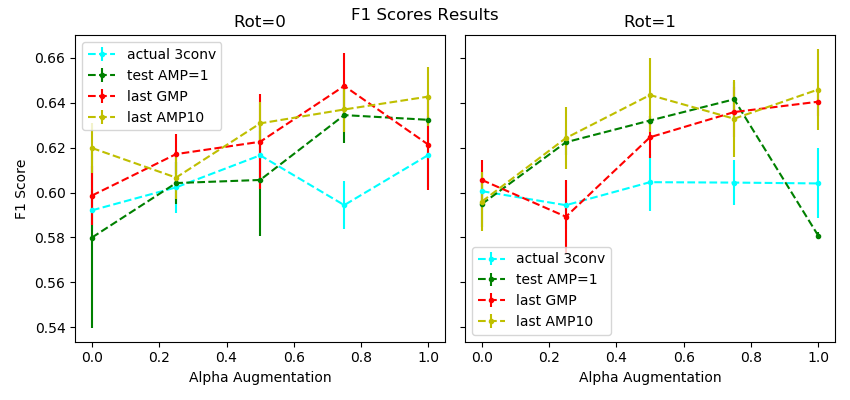

In [186]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4),tight_layout=True,sharex=True,sharey=True)
#ax[0].errorbar(df_results['AugmentAlpha'][:5],df_results['f1_mean'][:5],df_results['f1_std'][:5],fmt='bo',label='fail')
#ax[1].errorbar(df_results['AugmentAlpha'][:5],df_results['f1_mean'][5:],df_results['f1_std'][5:],fmt='bo',label='fail')
ax[0].errorbar(df_results2['AugmentAlpha'][:5],df_results2['f1_mean'][:5],df_results2['f1_std'][:5],color='cyan',fmt='.--',label='actual 3conv')
ax[1].errorbar(df_results2['AugmentAlpha'][:5],df_results2['f1_mean'][5:],df_results2['f1_std'][5:],color='cyan',fmt='.--',label='actual 3conv')
#ax[0].errorbar(df_results3['AugmentAlpha'][:5],df_results3['f1_mean'][:5],df_results3['f1_std'][:5],fmt='yo-',label='test 4conv')
#ax[1].errorbar(df_results3['AugmentAlpha'][:5],df_results3['f1_mean'][5:],df_results3['f1_std'][5:],fmt='yo-',label='test 4conv')
#ax[0].errorbar(df_results4['AugmentAlpha'][:5],df_results4['f1_mean'][:5],df_results4['f1_std'][:5],fmt='ro-',label='test 3Hid')
#ax[1].errorbar(df_results4['AugmentAlpha'][:5],df_results4['f1_mean'][5:],df_results4['f1_std'][5:],fmt='ro-',label='test 3Hid')
#ax[0].errorbar(df_results7['AugmentAlpha'][:5],df_results7['f1_mean'][:5],df_results7['f1_std'][:5],fmt='ro--',label='test stride 1')
#ax[1].errorbar(df_results7['AugmentAlpha'][:5],df_results7['f1_mean'][5:],df_results7['f1_std'][5:],fmt='ro--',label='test stride 1')

#ax[0].errorbar(df_results8['AugmentAlpha'][:5],df_results8['f1_mean'][:5],df_results8['f1_std'][:5],fmt='bo--',label='test noPool')
#ax[1].errorbar(df_results8['AugmentAlpha'][:5],df_results8['f1_mean'][5:],df_results8['f1_std'][5:],fmt='bo--',label='test noPool')
ax[0].errorbar(df_results9['AugmentAlpha'][:5],df_results9['f1_mean'][:5],df_results9['f1_std'][:5],fmt='g.--',label='test AMP=1')
ax[1].errorbar(df_results9['AugmentAlpha'][:5],df_results9['f1_mean'][5:],df_results9['f1_std'][5:],fmt='g.--',label='test AMP=1')
ax[0].errorbar(df_results10['AugmentAlpha'][:5],df_results10['f1_mean'][:5],df_results10['f1_std'][:5],fmt='r.--',label='last GMP')
ax[1].errorbar(df_results10['AugmentAlpha'][:5],df_results10['f1_mean'].iloc[[5,6,7,8,9]],df_results10['f1_std'].iloc[[5,6,7,8,9]],fmt='r.--',label='last GMP')
ax[0].errorbar(df_results11['AugmentAlpha'][:5],df_results11['f1_mean'][:5],df_results11['f1_std'][:5],fmt='y.--',label='last AMP10')
ax[1].errorbar(df_results11['AugmentAlpha'][:5],df_results11['f1_mean'][5:],df_results11['f1_std'][5:],fmt='y.--',label='last AMP10')
fig.suptitle('F1 Scores Results')
[ax_.set_title('Rot='+str(i)) for i,ax_ in enumerate(ax)]
ax[0].set_ylabel('F1 Score')
[ax_.set_xlabel('Alpha Augmentation') for ax_ in ax]
[ax_.legend() for ax_ in ax]


In [187]:
epochs,f1scores=list(),list()
print("|Rot| alpha | i |   f1   | Epoch |")
print("|---|-------|---|--------|-------|")
for rot_key in [0,1]:
    for alpha in [0,0.25,0.5,0.75,1]:
        f1scores=list()
        for i in range(5):
            path='/home/amorales/models/best_LCC_model_last__Rot'+str(rot_key)+'_Alpha'+str(alpha)+'_sampleo'+str(i)+'.pt'

            #path='/home/amorales/models/best_LCC_model-4conv__Rot'+str(rot_key)+'_Alpha'+str(alpha)+'_sampleo'+str(i)+'.pt'
            f1=torch.load(path)['f1_score']
            ep=torch.load(path)['epoca']
            print("| {} |  {:<4} | {} | {:6.4f} |  {:<4} |".format(rot_key,alpha,i,f1,ep))
            if i!=4:
                print("|---|-------|---|--------|-------|")
            else:
                print("|--------------------------------|-------|")
            f1scores.append(f1)
            epochs.append(ep)

        print("|  f1 avg   |   f1 std  | ep avg | ep sd |\n| {:9.7f} | {:8.7f} | {:6.1f} | {:<5.1f} |".format(np.mean(f1scores),np.std(f1scores),np.mean(epochs),np.std(epochs)))
        top_f1mean,top_f1std=cuatro_mayores(f1scores)
        top_epmean,top_epstd=cuatro_mayores(epochs)
        print("|----------------------------------------|")
        print("|  F1  best  trains  |  Ep  best  trains |\n| {:8.7f} | {:8.7f} | {:6.1f} | {:<5.1f} |".format(top_f1mean,top_f1std,top_epmean,top_epstd))
        print("|----------------------------------------|")


|Rot| alpha | i |   f1   | Epoch |
|---|-------|---|--------|-------|
| 0 |  0    | 0 | 0.5980 |  1589 |
|---|-------|---|--------|-------|
| 0 |  0    | 1 | 0.6130 |  2653 |
|---|-------|---|--------|-------|
| 0 |  0    | 2 | 0.6056 |  1921 |
|---|-------|---|--------|-------|
| 0 |  0    | 3 | 0.5781 |  1716 |
|---|-------|---|--------|-------|
| 0 |  0    | 4 | 0.3320 |  617  |
|--------------------------------|-------|
|  f1 avg   |   f1 std  | ep avg | ep sd |
| 0.5453226 | 0.1073176 | 1699.2 | 654.6 |
|----------------------------------------|
|  F1  best  trains  |  Ep  best  trains |
| 0.5986640 | 0.0130305 | 1969.8 | 411.9 |
|----------------------------------------|
| 0 |  0.25 | 0 | 0.6032 |  1623 |
|---|-------|---|--------|-------|
| 0 |  0.25 | 1 | 0.6261 |  3147 |
|---|-------|---|--------|-------|
| 0 |  0.25 | 2 | 0.5859 |  1511 |
|---|-------|---|--------|-------|
| 0 |  0.25 | 3 | 0.6161 |  1905 |
|---|-------|---|--------|-------|
| 0 |  0.25 | 4 | 0.6231 |  2855 |

In [188]:
epochs,f1scores=list(),list()
print("|Rot| alpha | i |   f1   | Epoch |")
print("|---|-------|---|--------|-------|")
for rot_key in [1,0]:
    for alpha in [0,0.25,0.5,0.75,1]:
        f1scores=list()
        for i in range(5):
            path='/home/amorales/models/best_LCC_model_lastAMP10__Rot'+str(rot_key)+'_Alpha'+str(alpha)+'_sampleo'+str(i)+'.pt'

            #path='/home/amorales/models/best_LCC_model-4conv__Rot'+str(rot_key)+'_Alpha'+str(alpha)+'_sampleo'+str(i)+'.pt'
            f1=torch.load(path)['f1_score']
            ep=torch.load(path)['epoca']
            print("| {} |  {:<4} | {} | {:6.4f} |  {:<4} |".format(rot_key,alpha,i,f1,ep))
            if i!=4:
                print("|---|-------|---|--------|-------|")
            else:
                print("|--------------------------------|-------|")
            f1scores.append(f1)
            epochs.append(ep)

        print("|  f1 avg   |   f1 std  | ep avg | ep sd |\n| {:9.7f} | {:8.7f} | {:6.1f} | {:<5.1f} |".format(np.mean(f1scores),np.std(f1scores),np.mean(epochs),np.std(epochs)))
        top_f1mean,top_f1std=n_mayores(f1scores)
        top_epmean,top_epstd=n_mayores(epochs)
        print("|----------------------------------------|")
        print("|  F1  best  trains  |  Ep  best  trains |\n| {:8.7f} | {:8.7f} | {:6.1f} | {:<5.1f} |".format(top_f1mean,top_f1std,top_epmean,top_epstd))
        print("|----------------------------------------|")


|Rot| alpha | i |   f1   | Epoch |
|---|-------|---|--------|-------|
| 1 |  0    | 0 | 0.5857 |  780  |
|---|-------|---|--------|-------|
| 1 |  0    | 1 | 0.6185 |  989  |
|---|-------|---|--------|-------|
| 1 |  0    | 2 | 0.5883 |  1385 |
|---|-------|---|--------|-------|
| 1 |  0    | 3 | 0.5914 |  1050 |
|---|-------|---|--------|-------|
| 1 |  0    | 4 | 0.3658 |  1117 |
|--------------------------------|-------|
|  f1 avg   |   f1 std  | ep avg | ep sd |
| 0.5499292 | 0.0928378 | 1064.2 | 196.1 |
|----------------------------------------|
|  F1  best  trains  |  Ep  best  trains |
| 0.5959739 | 0.0131527 | 1135.2 | 151.1 |
|----------------------------------------|
| 1 |  0.25 | 0 | 0.5974 |  657  |
|---|-------|---|--------|-------|
| 1 |  0.25 | 1 | 0.6355 |  933  |
|---|-------|---|--------|-------|
| 1 |  0.25 | 2 | 0.6336 |  2328 |
|---|-------|---|--------|-------|
| 1 |  0.25 | 3 | 0.6009 |  995  |
|---|-------|---|--------|-------|
| 1 |  0.25 | 4 | 0.6272 |  1707 |

In [ ]:
data=torch.tensor([9,8,7,6,0,0,0,0])
mask=[1,1,1,1,0,0,0,0]
mask_t=torch.tensor(mask).bool()
mask_bool=np.asarray(mask).astype('bool')
print(mask_bool,mask_t)
#print(data[mask], data[mask_t])
for i in range(len(mask)):
    if mask[i]==1:
        mask[i]=True
    else:
        mask[i]=False
#print(mask)
#print(data[mask], data[mask_t])

In [23]:
def n_mayores(lista):
    menor=min(lista)
    lista.remove(menor)
    """menor=min(lista)
    lista.remove(menor)"""
    return np.mean(lista),np.std(lista)

In [ ]:
df_results.to_csv('results.csv',header=False, index=False)

In [ ]:
with open('results2.pkl', 'wb') as handle:
    pickle.dump(df_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

**INTERPOLACION**


In [ ]:
# phase ordenada
phi = np.sort(np.random.rand(50))

# magnitude 
mag = np.sin(2.0*np.pi*2*phi) + 0.1*np.random.randn(len(phi))

# errores cuadraticos de cada punto con respecto a la phase (?)
window = lambda phi_point : np.exp(-0.5*(phi_point-phi)**2/0.05**2)

# espaciado regular de 100 pts entre 0 y 1
phi_interp = np.linspace(0, 1, num=100)

# cálculo de la interpolacion (prediccion) de la magnitud "basado en la cercania entre los puntos"
mag_interp = np.array([np.sum(window(phi_val)*mag)/np.sum(window(phi_val)) for phi_val in phi_interp])

plt.figure()
plt.scatter(phi, mag)
plt.plot(phi_interp, mag_interp, lw=2, c='r')



In [ ]:
column_names_lc = ["mjd", "mag", "err"]
column_names_fill = ["mjd", "mag", "err", "phase", "real"]
df_test = pd.DataFrame(np.random.random((10,3)),columns=column_names_lc)
df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
display(df_test, df_zeros)

In [ ]:
df_test["phase"] = df_test["mag"]+df_test["mjd"]

In [ ]:
while len(df_test) < 15:
    df_test = df_test.append(df_zeros, ignore_index=True, sort=False)
    print("ok")

In [ ]:
display(df_test)

In [ ]:
df_test = df_test.fillna(1)
display(df_test)

In [ ]:
 # for cada input
        #    usar mascara para filtrar datos reales
        #    cada input sera de 5x335 -> 5xn (n datos reales) -> unsqueeze(0) -> 1x5xn
        #    model.forward(input)
        #    loss=criterion
        #    sumar loss
        #    backward
        # optimizer.step

In [ ]:
df_tensor = torch.from_numpy(df_test.values.astype('float32'))
n = sum(df_tensor[:,4] == 1)
data = df_tensor[:n]
data

In [ ]:
n=sum(df_test['real']==1)

In [ ]:
df_test_real = df_test[:n]

In [ ]:
df_test_real.transpose().shape

In [ ]:
df_tensor = torch.from_numpy(df_test_real.values.astype('float32'))
df_tensor = df_tensor.transpose(0,1).unsqueeze(0)
#df_tensor = df_tensor.unsqueeze(0)
df_tensor.shape

In [ ]:

for i in range(len(df_test)):
    if df_test['real'][i] == 1:
        print("ok")
    else:
        n=i
        print(n)
        break